In [4]:
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import math

from pandas import Series
from statistics import mean
from statistics import median

from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import plotly as py
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.tsa.stattools as st
from scipy import stats as stats

!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=9999)

import warnings
warnings.filterwarnings("ignore")

In [0]:
# https://data.kcmo.org/311/311-Call-Center-Service-Requests/7at3-sxhp
kc_311_calls = pd.read_csv('/content/drive/My Drive/IST718/311_Call_Center_Service_Requests.csv') # large

# https://data.kcmo.org/Budget/Budget-for-budget-kcmo-gov/whg3-khkh
kc_budget = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Budget_for_budget.kcmo.gov.csv')

# https://data.kcmo.org/Budget/KCMO-FY-2012-2020-Submitted-Adopted-and-Actual-Bud/mwmk-j86a #25mb
kc_expenses = pd.read_csv('/content/drive/My Drive/IST718/KCMO_FY_2012-_2020_Submitted__Adopted__and_Actual_Budget_-_Expenditures.csv')

In [6]:
kc_311_calls.DEPARTMENT.unique()

array(['NHS', 'Northland', 'Water Services', 'Public Works', 'Health',
       'Parks and Rec', 'City Managers Office',
       'City Planning and Development', 'KCPD', 'Finance', 'South',
       'Fire', 'Aviation', 'General Service', 'Parks & Rec',
       'Convention and Entertainment Center', 'NCS',
       'Information Technology', 'Parks & Recreation',
       'Housing Community Dev', 'IT', 'Municipal Court'], dtype=object)

Clean data

In [7]:
kc_311_calls['DEPARTMENT'].loc[kc_311_calls.DEPARTMENT=='Parks & Rec'] = 'Parks and Rec'
kc_311_calls['DEPARTMENT'].loc[kc_311_calls.DEPARTMENT=='Parks & Recreation'] = 'Parks and Rec'
kc_311_calls['DEPARTMENT'].loc[kc_311_calls.DEPARTMENT=='IT'] = 'Information Technology'
kc_311_calls['DEPARTMENT'].loc[kc_311_calls.DEPARTMENT=='Housing Community Dev'] = 'NHS'
kc_311_calls['DEPARTMENT'].loc[kc_311_calls.DEPARTMENT=='NCS'] = 'NHS'
kc_311_calls.DEPARTMENT.value_counts()

NHS                                    728914
Public Works                           328815
Water Services                         196823
Parks and Rec                           81919
KCPD                                    32411
Health                                  31064
City Planning and Development           11394
City Managers Office                    10483
Northland                                4966
Finance                                  1513
Fire                                      562
General Service                           464
South                                     295
Aviation                                  145
Convention and Entertainment Center        51
Information Technology                     20
Municipal Court                             8
Name: DEPARTMENT, dtype: int64

In [8]:
kc_budget['Department'].loc[kc_budget.Department=='Health and Medical Care'] = 'Health'
kc_budget['Department'].loc[kc_budget.Department=='Convention and Entertainment Facilities'] = 'Convention and Tourism'
kc_budget.Department.value_counts()

Water Services                        13870
Parks and Recreation                  11911
Public Works                          10698
Police                                 7534
Health                                 6511
Aviation                               6329
Fire                                   5414
Neighborhoods and Housing Services     4817
General Services                       4114
City Planning and Development          2567
Office of the City Manager             2274
Convention and Tourism                 2033
Municipal Court                        1447
Finance                                1256
Offices of Mayor and Council           1055
Human Resources                         928
Law                                     832
Human Relations                         829
Economic Development                    646
Office of the City Auditor              215
Office of the City Clerk                203
Transportation Authorities              136
Boards of Election Commissioners

In [9]:
kc_expenses['department'].loc[kc_expenses.department=='Health and Medical Care'] = 'Health'
kc_expenses['department'].loc[kc_expenses.department=='Convention and Entertainment Facilities'] = 'Convention and Tourism'
kc_expenses.department.value_counts()

Public Works                          26774
Parks and Recreation                  23616
Water Services                        23069
Health                                16377
Police                                10607
Fire                                   9666
Neighborhoods and Housing Services     9420
Aviation                               8911
General Services                       6749
City Planning and Development          4460
Office of the City Manager             4092
Convention and Tourism                 3555
Municipal Court                        2564
Offices of Mayor and Council           2009
Finance                                1969
Human Relations                        1697
Human Resources                        1408
Law                                     994
Economic Development                    861
Office of the City Clerk                305
Office of the City Auditor              275
Transportation Authorities              196
Boards of Election Commissioners

In [0]:
# Number of 311 Calls vs Budget (2012 - 2019)
kc_311_calls_12_19 = kc_311_calls[(kc_311_calls['CREATION YEAR']>=2012) & (kc_311_calls['CREATION YEAR']<=2019)]

# 311 calls
groups = kc_311_calls_12_19.groupby(["DEPARTMENT", "CREATION YEAR"])
call_totals = pd.DataFrame({'Total' : groups.size()}).reset_index()

# Budget
groups = kc_budget.groupby(["Department", "Fiscal Year"])["Approved Amount"]
budget_totals = pd.DataFrame({'Total' : groups.sum()}).reset_index()

# Expenses
groups = kc_expenses.groupby(["department", "year"])["actuals"]
expenses_totals = pd.DataFrame({'Total' : groups.sum()}).reset_index()

In [0]:
# dept matching between datasets
mapping = [
  {'budget':'Neighborhoods and Housing Services', 'call':'NHS', 'expense':['trash',
                                                                           'recycl', 
                                                                           'neighborhood', 
                                                                           'Regulated Industries', 
                                                                           'Housing',
                                                                           'Community',
                                                                           'homeowner',
                                                                           'Dangerous Building',
                                                                           'Tow Service',
                                                                           'Animal Health',
                                                                           'Public Safety',
                                                                           'Homestead',
                                                                           'Regulated Industr',
                                                                           'Dangerous Building']}, 
  {'budget':'Public Works', 'call':'Public Works', 'expense':['public works', 
                                                              'construction',
                                                              'maintenance', 
                                                              'engineer',
                                                              'facilities',
                                                              'facility',
                                                              'fleet',
                                                              'lakes',
                                                              'stormwater',
                                                              'solid waste',
                                                              'traffic',
                                                              'parking',
                                                              'sewer']},
  {'budget':'Water Services', 'call':'Water Services'}, 
  {'budget':'Parks and Recreation', 'call':'Parks and Rec', 'expense':['park ', 'parks', 'rec ', 'Recreation', 
                                                                       'snow', 'ice ', 'Fountain', 
                                                                       'Central Region Blvds-West Park', 
                                                                       'Observation Park', 'Iser Park', 
                                                                       'South Region Blvds - West Park',
                                                                       'West Bottoms Garage', 'Ivanhoe Park',
                                                                       'Golf Crs Oper-Hodge Park',
                                                                       'Golf Crs Oper-Minor Park', 
                                                                       'Columbus Park', 'Natural Resource']},
  {'budget':'Police', 'call':'KCPD', 'expense':['police']}, 
  {'budget':'Health', 'call':'Health', 'expense':['health', 
                                                  'safety',
                                                  'immunization',
                                                  'violence',
                                                  'economic mobility',
                                                  'disease',
                                                  'HIV', 'Flu', 'Opioid', 'STD', 'Food Handl',
                                                  'vaccin', 'Aim4Peace', 'Poison', 'disease', 
                                                  'Tuberculosis', 'TB', 'Food Inspection',
                                                  'one touch']}, 
  {'budget':'City Planning and Development', 'call':'City Planning and Development', 'expense':['plans', 
                                                                                                'planning',
                                                                                                'board',
                                                                                                'commission',
                                                                                                'zoning',
                                                                                                'Historic Preservation', 
                                                                                                'Development Management',
                                                                                                'Urban Redevelopment',
                                                                                                'Land Development'
                                                                                                'Permits', 'Permits and Development']}, 
  {'budget':'Office of the City Manager', 'call':'City Managers Office', 'expense':['Ada '
                                                                                    'disabilit', 
                                                                                    'communication',
                                                                                    'datakc',
                                                                                    'contract',
                                                                                    'EMS Education',
                                                                                    'EMS Administration', 
                                                                                    'EMS Oversight', 
                                                                                    'EMS Training', 
                                                                                    'Emergency Medical Training'
                                                                                    'Emergency Medical Services',
                                                                                    'NTDF', 
                                                                                    'Neighborhood Tourist', 
                                                                                    'Creative', 
                                                                                    'Economic',
                                                                                    'Emergency',
                                                                                    'Environment']},
  #{'budget':'', 'call':'NCS'},
  #{'budget':'', 'call':'Northland'},
  {'budget':'Finance', 'call':'Finance'},
  {'budget':'Fire', 'call':'Fire'},
  {'budget':'General Services', 'call':'General Service'},
  #{'budget':'', 'call':'South'},
  {'budget':'Aviation', 'call':'Aviation'},
  {'budget':'Convention and Tourism', 'call':'Convention and Entertainment Center'} 
  #{'budget':'', 'call':'Information Technology'},
  #{'budget':'Municipal Court', 'call':'Municipal Court'} .. none in dataset for years specified
]

#vendor['dept'].unique()

In [0]:
budget_totals = budget_totals.set_index('Fiscal Year')

In [13]:
# plot dept budget by year
palette = sns.color_palette('Paired', 13).as_hex()


fig = go.Figure()
for m in range(0, len(mapping)):
    fig.add_trace(go.Scatter(x=budget_totals[budget_totals['Department']==mapping[m]['budget']].index, 
                             y=budget_totals[budget_totals['Department']==mapping[m]['budget']].Total, 
                             name=mapping[m]['budget'], line_color=palette[m]))

fig.update_layout(title_text='Total Dept Budget per Year',
                  xaxis_rangeslider_visible=False)
fig.show()

Groupings

NHS R-squared: -0.48


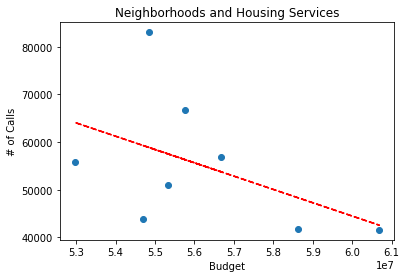

Public Works R-squared: 0.6


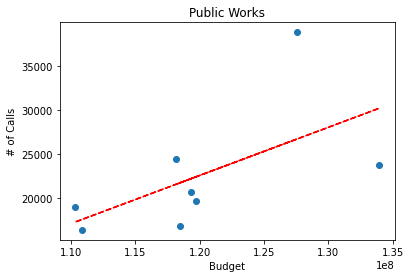

Water Services R-squared: 0.42


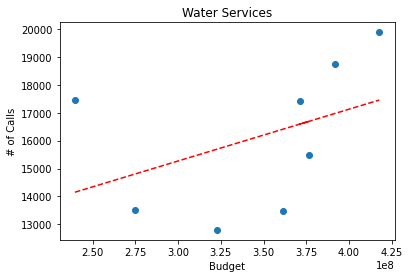

Parks and Rec R-squared: 0.75


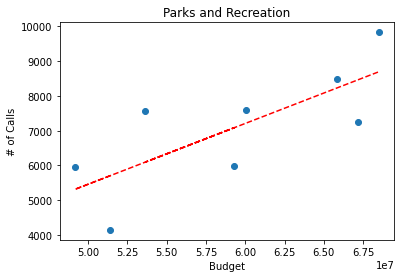

KCPD R-squared: 0.92


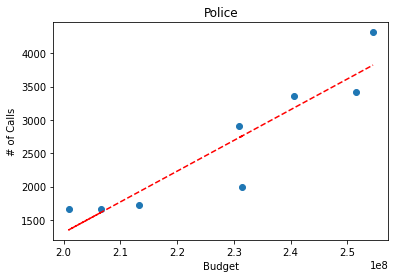

Health R-squared: 0.54


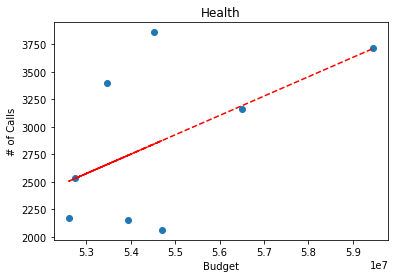

City Planning and Development R-squared: 0.7


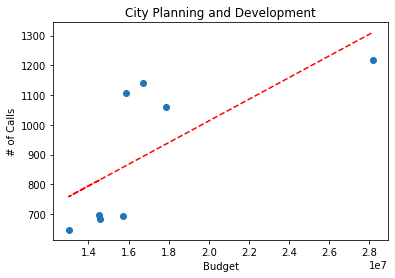

City Managers Office R-squared: 0.96


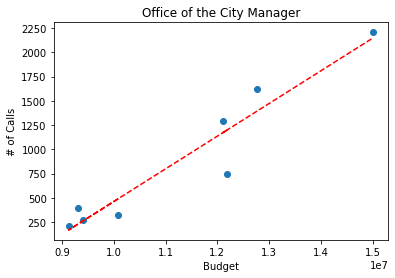

Finance R-squared: 0.91


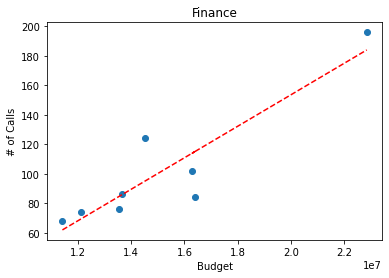

Fire R-squared: 0.03


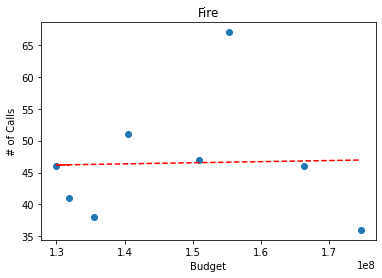

General Service R-squared: -0.43


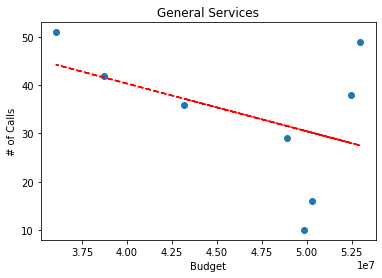

Aviation R-squared: 0.16


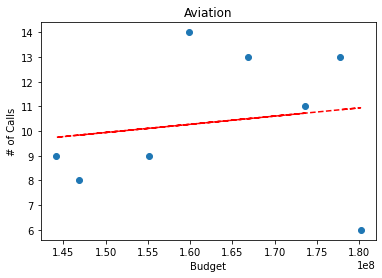

Convention and Entertainment Center R-squared: 0.71


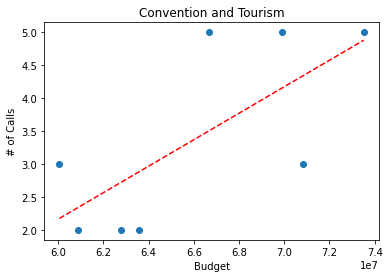

In [14]:
#Budget vs calls 

!pip install scipy
for s in range(0, len(mapping)):

  budget_totals_sub = budget_totals[budget_totals['Department']==mapping[s]['budget']]
  call_totals_sub = call_totals[call_totals['DEPARTMENT']==mapping[s]['call']]

  print(mapping[s]['call'] + ' R-squared: ' + str(round(stats.pearsonr(budget_totals_sub.Total, call_totals_sub.Total)[0], 2)))

  # Plot
  plt.scatter(budget_totals_sub.Total, call_totals_sub.Total)
  plt.title(mapping[s]['budget'])
  plt.xlabel('Budget')
  plt.ylabel('# of Calls')

  z = np.polyfit(budget_totals_sub.Total, call_totals_sub.Total, 1)
  p = np.poly1d(z)
  plt.plot(budget_totals_sub.Total,p(budget_totals_sub.Total),"r--")


  plt.show()



NHS R-squared: 0.93


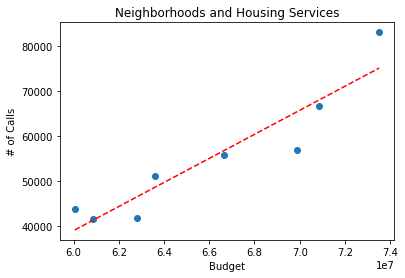

Public Works R-squared: 0.39


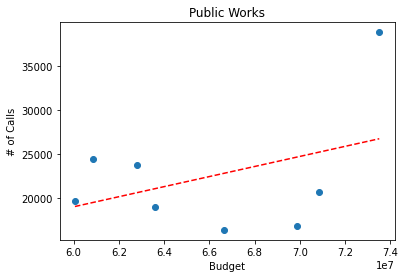

Water Services R-squared: 0.73


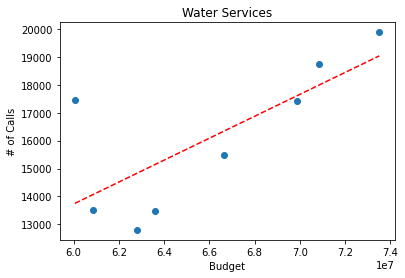

Parks and Rec R-squared: 0.87


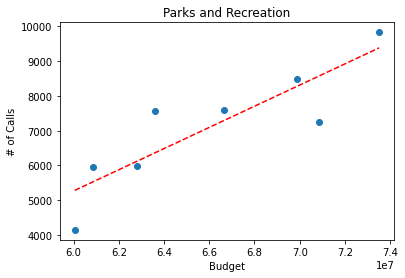

KCPD R-squared: 0.98


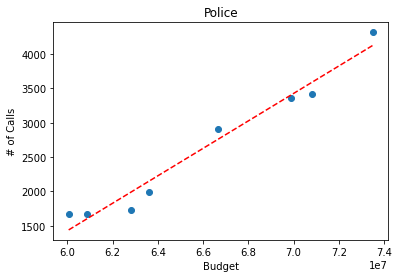

Health R-squared: 0.9


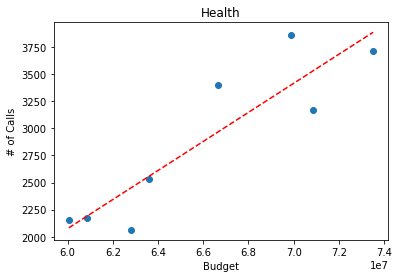

City Planning and Development R-squared: 0.93


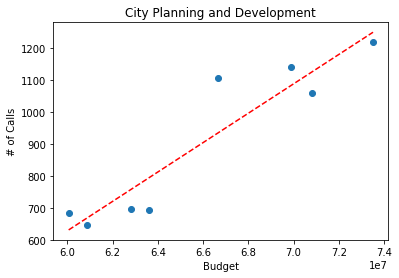

City Managers Office R-squared: 0.96


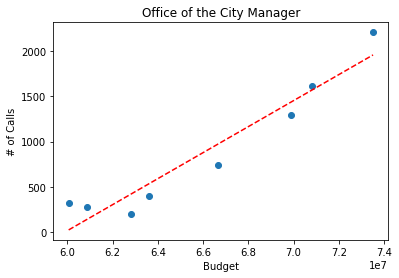

Finance R-squared: 0.76


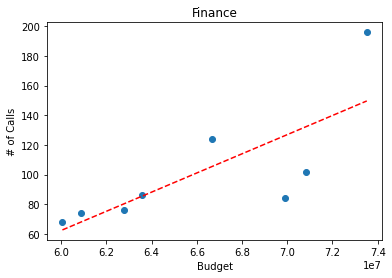

Fire R-squared: 0.15


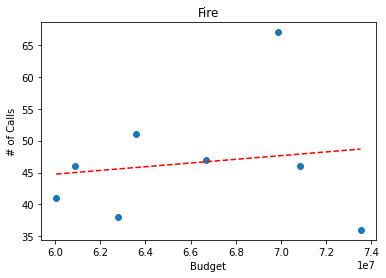

General Service R-squared: 0.77


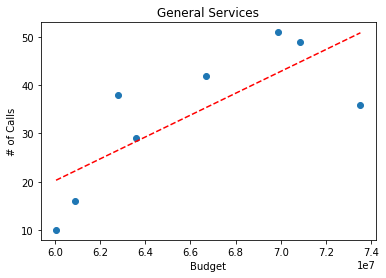

Aviation R-squared: 0.3


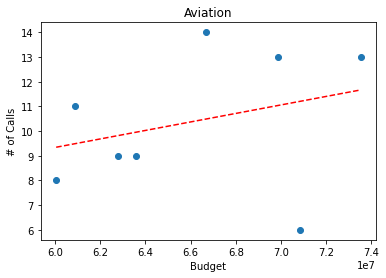

Convention and Entertainment Center R-squared: 0.71


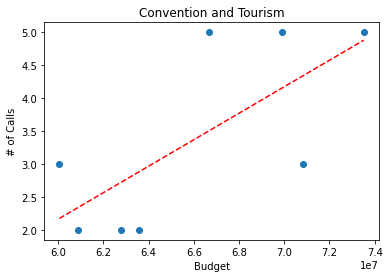

In [15]:
#Expenses vs calls 

#!pip install scipy
depts, corrs = [], []

for s in range(0, len(mapping)):

  depts.append(mapping[s]['call'])

  expenses_totals_sub = expenses_totals[expenses_totals['department']==mapping[s]['budget']]
  call_totals_sub = call_totals[call_totals['DEPARTMENT']==mapping[s]['call']]

  corr = round(stats.pearsonr(budget_totals_sub.Total, call_totals_sub.Total)[0], 2)
  corrs.append(corr)
  print(mapping[s]['call'] + ' R-squared: ' + str(corr))
  
  # Plot
  plt.scatter(budget_totals_sub.Total, call_totals_sub.Total)
  plt.title(mapping[s]['budget'])
  plt.xlabel('Budget')
  plt.ylabel('# of Calls')

  z = np.polyfit(budget_totals_sub.Total, call_totals_sub.Total, 1)
  p = np.poly1d(z)
  plt.plot(budget_totals_sub.Total,p(budget_totals_sub.Total),"r--")

  plt.show()

# table of r-squared values
import plotly.graph_objects as go

df = pd.DataFrame({'depts':depts, 'corrs':corrs})
df = df.sort_values(by=['corrs'], ascending=False)
values = [df.depts, df.corrs]

fig = go.Figure(data=[go.Table(
  columnorder = [1,2],
  columnwidth = [70,30],
  header = dict(
    values = [['<b>DEPARTMENT</b>'], ['<b>R-SQUARED</b>']],
    line_color='darkslategray',
    fill_color='royalblue',
    align=['left','center'],
    font=dict(color='white', size=12),
    height=40
  ),
  cells=dict(
    values=values,
    line_color='darkslategray',
    fill=dict(color=['paleturquoise', 'white']),
    align=['left', 'center'],
    font_size=12,
    height=30)
    )
])
fig.show()


In [16]:
np.set_printoptions(threshold=2000)
kc_311_calls['REQUEST TYPE'].unique()

array(['Trees-Land Bank-Hazardous', 'Property Violations',
       'Prop/Build/Construct-Property Maintenance-NNI',
       'Water-Pipeline Referral-Restoration',
       'Water-Leak-At Curb / In Yard', 'Signs-Traffic Sign-Graffiti',
       'Lights / Signals-Traffic Signal-Signal out',
       'Sewer-Sewer Backup / Leak-In a house', 'Water-Leak-Hydrant',
       'Signs-Traffic Sign-Missing – Emergency',
       'Streets / Roadways / Alleys-Snow / Ice-District 1',
       'Trash / Recycling-Trash Collection-Missed by City',
       'Water-No Water / Pressure-Low Pressure',
       'Stormwater-Stormwater Referral-Repair',
       'Trash / Recycling-Leaf / Brush-Missed Pick Up',
       'Public Health-Services-Healthy Homes Information',
       'Streets / Roadways / Alleys-Broken Asphalt-District 2',
       'Streets / Roadways / Alleys-Guardrail-Bridge',
       'Animals / Pets-Stray-At Large - Aggressive',
       'Streets / Roadways / Alleys-Pothole-District 3',
       'Streets / Roadways / Alleys-P

Can rat infestation be predicted?

In [0]:
# rats
txt = 'Animals / Pets-Rat'
rat_calls = kc_311_calls[kc_311_calls['REQUEST TYPE'].str.match(txt)]
rat_calls.head()

rat_calls['CREATION DATE'] = pd.to_datetime(rat_calls['CREATION DATE'], format='%m/%d/%Y', errors='coerce')
rat_calls = rat_calls.set_index('CREATION DATE')

In [18]:
rat_calls_m = pd.DataFrame(rat_calls.resample('M').count()['CASE ID'].values, index=rat_calls.resample('M').count().index, columns=['value'])

# plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=rat_calls_m.index, y=rat_calls_m.value, name='# of Calls about Rats',
                          line_color='deepskyblue'))
fig.update_layout(title_text='# of 311 Calls about Rats',
                  xaxis_rangeslider_visible=False)
fig.show()

Can we forecast the budget based on calls?

In [0]:
# import vendor payments to compare monthly

# https://data.kcmo.org/Budget/Vendor-Payments-Calendar-Year-2014/96p4-as6r (2014)
# code used to gather 2010-2019, but for simplicity, I've exported into 1 csv file: 
# KC_Vendor_Payments_2010_to_2019.csv
'''
vendor_2010 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2010.csv')
vendor_2011 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2011.csv')
vendor_2012 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2012.csv')
vendor_2013 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2013.csv')
vendor_2014 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2014.csv')
vendor_2015 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2015.csv')
vendor_2016 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2016.csv')
vendor_2017 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2017.csv')
vendor_2018 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2018.csv')
vendor_2019 = pd.read_csv('https://raw.githubusercontent.com/vksyr/IST718/master/Vendor_Payments_Calendar_Year_2019.csv')

vendor_2010.rename(columns = {' Payment Amount ':'Payment Amount'}, inplace=True)
vendor_2011.rename(columns = {' Payment Amount ':'Payment Amount'}, inplace=True)
vendor_2012.rename(columns = {' Payment Amount ':'Payment Amount'}, inplace=True)
vendor_2013.rename(columns = {'DeptID_Descr':'Dept Descr'}, inplace=True)
vendor_2014.rename(columns = {'PAYMENT_DATE':'Payment Date', 'PAYMENT_AMOUNT':'Payment Amount','DEPTID_DESCR':'Dept Descr'}, inplace=True)
vendor_2015.rename(columns = {'PAYMENT_DATE':'Payment Date', 'PAYMENT_AMOUNT':'Payment Amount','DEPTID_DESCR':'Dept Descr'}, inplace=True)
vendor_2016.rename(columns = {'DeptID_Descr':'Dept Descr'}, inplace=True)
vendor_2017.rename(columns = {'DeptID_Descr':'Dept Descr'}, inplace=True)
vendor_2018.rename(columns = {'DeptID_Descr':'Dept Descr'}, inplace=True)
vendor_2019.rename(columns = {'DeptID_Descr':'Dept Descr'}, inplace=True)

vendor = pd.concat([vendor_2010, vendor_2011, vendor_2012, vendor_2013, vendor_2014, 
                    vendor_2015, vendor_2016, vendor_2017, vendor_2018, vendor_2019])


# saving the dataframe 
vendor.to_csv('/content/drive/My Drive/IST718/KC_Vendor_Payments_2010_to_2019.csv', header=True, index=False) 
'''


In [0]:
vendor = pd.read_csv('/content/drive/My Drive/IST718/KC_Vendor_Payments_2010_to_2019.csv')

Cleanup vendor payment data

In [0]:
vendor['Payment Date'] = pd.to_datetime(vendor['Payment Date'], format='%m/%d/%Y', errors='coerce')
vendor = vendor.set_index('Payment Date')

vendor = vendor[vendor['Dept Descr'].notna()]
vendor = pd.DataFrame({'amount':vendor['Payment Amount'], 'dept':vendor['Dept Descr'].values}, index=vendor.index)

ARIMA functions

In [0]:
# define a function to run auto arima and search for best model parameters
def find_orders(ts, exog=None):

    stepwise_model = pm.auto_arima(ts, start_p=1, start_q=1, max_p=4, max_q=14,
                                exogenous=exog, 
                                m=12, seasonal=True, stationary=False,
                                stepwise=True, trend='ct',
                                suppress_warnings=True, trace=False, 
                                error_action='ignore')

    return stepwise_model.order, stepwise_model.seasonal_order

def fit_sarimax_model(ts, exog=None, order=(1,1,1), seasonal_order=(0, 0, 0, 12), summary=True, plot=True):
  
    # fit model with exog
    model = sm.tsa.statespace.SARIMAX(ts, 
                                  exog = exog,  
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  trend='ct',
                                  enforce_stationarity=True,
                                  enforce_invertibility=False)

    output = model.fit(d=0)
    
    if summary==True:
        print(output.summary())

    if plot==True:
        # plot model diagnostics
        output.plot_diagnostics(figsize=(15, 18))
        plt.show()
        
    return output

def get_predictions(test, exog, model_output, plot=True, show=True):
    
    # Use the model to forecast twelve months into 2018 and store the confidence intervals
    pred = model_output.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False, exog=exog)
    pred_ci = pred.conf_int()
    
    # Plot the actual results for 2018 vs the projected results. 
    ax = test['2019-01-31':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(8,6))
    
    
    if plot:
        #Plot observed and predicted values with confidence interval
        ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

        ax.set_xlabel('Date')
        ax.set_ylabel('Household Value')
        plt.legend(loc='upper left')
        plt.show()

    
    if show:
        
        # Obtain the predicted mean, merge with the actual values, and compute the MSE. 
        y_pred = pred.predicted_mean.reset_index()
        y_pred.columns = ['date', 'value']
        
        y_test = test.reset_index()
        
        # Compute the mean square error / RMSE
        mse = mean_squared_error(y_test.value, y_pred.value)

        rmse = math.sqrt(mse)
        r2 = r2_score(y_test.value, y_pred.value)

        # Print the results. 
        print('RMSE: ' +  str(format(round(rmse, 3))))
        print('R-squared: ' + str(format(round(r2, 3))))

def get_future(ds, exog, model_output, plot):

    # Get forecast and confidence interval from base model, by steps 60
    

    #future_1y= model_output.forecast(steps=12, exog=exog)
    future_1y = model_output.get_forecast(steps=12, exog=exog, dynamic=True)
    future_conf_1y = future_1y.conf_int(steps=12)

    if plot: # plot results

        # 1 yr
        ax = ds.plot(label='Observed', figsize=(12, 8))
        future_1y.predicted_mean.plot(ax=ax, label='Forecast')
        ax.fill_between(future_conf_1y.index,
                        future_conf_1y.iloc[:, 0],
                        future_conf_1y.iloc[:, 1], color='k', alpha=.25)
        ax.set_xlabel('Date')
        ax.set_ylabel('Returns')
        ax.set_title('1-Year Forecast')
        ax.legend()
        plt.show()        

    df_out = future_conf_1y
    df_out['yhat'] = future_1y.predicted_mean
    df_out.columns = ['yhat_lower', 'yhat_upper', 'yhat']


    gain_df = pd.DataFrame({'value':df_out['yhat'].values, 'date':df_out.index})
    lastObs = pd.DataFrame({'value':ds.iloc[-1]['value'], 'date':ds.index[-1]}, index=[0])

    # preappend one row from actuals to forecast so that roi can be projected.
    gain_df = pd.concat([ lastObs, gain_df])
    gain_df = gain_df.set_index('date')

    roi = calculate_gain(gain_df, plot=False)

    print('1-Year ROI:')
    print(roi)
    return (df_out)

# function to calculate gain percentage (ROI) on previous 2, 5 and 10 years
# source: https://github.com/gioamorim80/Zillow-Time-Series/blob/master/Module%204%20Final%20Project.ipynb
def calculate_gain(ts, plot=True): 
    
    '''Takes a time series and performs calculations on returns over investments
    for period of 1 year'''
    
    # calculates ROI by taking current value, decreasing investment(value at x steps in past) and 
    # dividing by investment. Multiplies by 100 to get percentage number
    roi_1 = (ts - ts.shift(periods=12))/ts.shift(periods=12)*100
    roi_1.dropna(inplace=True)  

    # plot results
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=roi_1.index, y=roi_1.value, name='1-Year Investment',
                                 line_color='deepskyblue'))
        
        fig.update_layout(title_text='ROI',
                          yaxis_title="ROI (%)", 
                          xaxis_rangeslider_visible=False)
        fig.show()
    
    # saves new ts with returns for 1 period
    return roi_1

Granger test, and SARIMAX model evaluation

In [52]:
# run granger causailty test, determining if dept 311-call volume affects dept vendor payment
def doTest(mapIndex):
      
  map = mapping[mapIndex]

  print('############# ' + map['call'] + ' #############')

  # vendor payments
  if(mapIndex==0):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][13].lower())>-1)]

  elif(mapIndex==1):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1)]

  elif(mapIndex==3):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][13].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][14].lower())>-1)]

  elif(mapIndex==4):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1)]     

  elif(mapIndex==5):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][13].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][14].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][15].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][16].lower())>-1) |
                            (vendor['dept'].str.lower().str.find(map['expense'][17].lower())>-1) |
                            (vendor['dept'].str.lower().str.find(map['expense'][18].lower())>-1)]             

  elif(mapIndex==6):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1)]

  elif(mapIndex==7):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][13].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][14].lower())>-1)]  



  vendor_dept = vendor_dept.resample('M').sum()

  # 311 calls
  kc_311_dept = kc_311_calls[kc_311_calls['DEPARTMENT']==map['call']]
  kc_311_dept['CREATION DATE'] = pd.to_datetime(kc_311_dept['CREATION DATE'], format='%m/%d/%Y', errors='coerce')
  kc_311_dept = kc_311_dept[(kc_311_dept['CREATION DATE'] >= '2010-04-30') & (kc_311_dept['CREATION DATE'] <= '2019-12-31') ]

  #kc_311_dept = kc_311_dept.reset_index()
  kc_311_dept = kc_311_dept.set_index('CREATION DATE')
  kc_311_dept = kc_311_dept.resample('M').count()

  # Granger Causality Test
  offset = len(vendor_dept.amount) - len(kc_311_dept['CASE ID'])
  vendor_dept = vendor_dept.iloc[offset:,:]

  df = pd.DataFrame({'y':vendor_dept.amount, 'x':kc_311_dept['CASE ID']})
  gr = st.grangercausalitytests(df, maxlag = 12, addconst=True, verbose=False)

  aics, lags, pvalues = [], [], []

  #print('Granger Test: ')

  for g in range(1, len(gr)+1):
    if ((gr[g][0]['lrtest'][1] < 0.05) & 
      (gr[g][0]['params_ftest'][1] < 0.05) & 
      (gr[g][0]['ssr_chi2test'][1] < 0.05) & 
      (gr[g][0]['ssr_ftest'][1] < 0.05)):
        #print('Lag ' + str(g) + ' is significant.')
        lag = g

        # shift by lag
        kc_311_dept_lag = kc_311_dept.shift(lag)
        kc_311_dept_lag = kc_311_dept_lag.iloc[lag:,:]
        #kc_311_dept_lag = kc_311_dept_lag.fillna(method='bfill')


        vendor_dept_aligned_w_lag = vendor_dept.iloc[lag:,:]
        #vendor_dept_aligned_w_lag = vendor_dept_aligned_w_lag.fillna(method='bfill')

        # train/test datasets
        df = pd.DataFrame({'value':vendor_dept_aligned_w_lag['amount']}, index=vendor_dept_aligned_w_lag.index)
        col='value'
        pd_before2019 = pd.DataFrame(df[col].loc[:'2018'], index=df.loc[:'2018'].index)
        pd_2019 = pd.DataFrame(df[col].loc['2019'], index=df.loc['2019'].index)
        train = pd_before2019
        train.columns = [col]
        test = pd_2019 
        test.columns = [col]

        # exog
        exogs = pd.DataFrame(data=kc_311_dept_lag['CASE ID'].values, index=kc_311_dept_lag.index, columns=['311_Calls'])

        # find best orders
        orders = find_orders(train, exogs.loc[:'2018']) # takes a bit of time, best --> ((1, 1, 1), (1, 0, 1, 12))
        #print('Using orders: ' + str(orders))
        
        # base model
        model_output = fit_sarimax_model(train, exogs.loc[:'2018'], order=orders[0], seasonal_order=orders[1], summary=False, plot=False)  
        aics.append(model_output.aic)
        lags.append(lag)
        pvalues.append(list(model_output.pvalues)[2])


  if len(aics) > 0:
    for a in range(0, len(aics)):
      print('311_Call Lag: ' + str(lags[a]) + ', AIC: ' + str(np.round(aics[a], 3)) + ', 311_Call p-value: ' + str(np.round(pvalues[a], 6)) )

  else:
    print('No significant lags found.')

  print('')
  print('')
  print('')

#doTest(0) # NHS, no significant lags
#doTest(1) # pw, no significant lags
doTest(3) # parks - lag 11, p-value < 0.05, AIC: 3329.497
#doTest(4) # police, 311_Call Lag: 8, AIC: 2788.082, 311_Call p-value: 0.909 
#doTest(5) # health, no significant lags
#doTest(6) # planning & dev, 311_Call Lag: 12, AIC: 3084.973, 311_Call p-value: 0.0
#doTest(7) # city mgmt, no significant lags


############# Parks and Rec #############
311_Call Lag: 4, AIC: 3574.725, 311_Call p-value: 0.0
311_Call Lag: 9, AIC: 3419.123, 311_Call p-value: 0.0
311_Call Lag: 10, AIC: 3372.786, 311_Call p-value: 0.0
311_Call Lag: 11, AIC: 3329.497, 311_Call p-value: 0.0





############# Parks and Rec #############


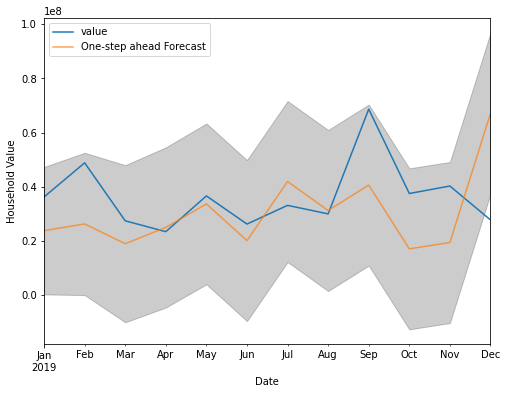

RMSE: 18378814.466
R-squared: -1.394
1-Year ROI:
               value
date                
2020-12-31 -42.43445


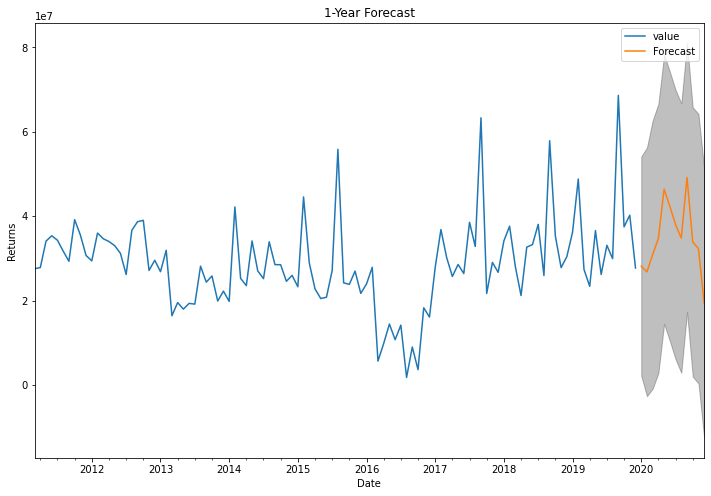

1-Year ROI:
                value
date                 
2020-12-31 -30.161226





In [57]:
def doForecast(mapIndex, lag):

  map = mapping[mapIndex]

  print('############# ' + map['call'] + ' #############')

  # vendor payments
  if(mapIndex==0):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][13].lower())>-1)]

  elif(mapIndex==1):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1)]

  elif(mapIndex==3):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][13].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][14].lower())>-1)]

  elif(mapIndex==4):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1)]     

  elif(mapIndex==5):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][13].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][14].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][15].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][16].lower())>-1) |
                            (vendor['dept'].str.lower().str.find(map['expense'][17].lower())>-1) |
                            (vendor['dept'].str.lower().str.find(map['expense'][18].lower())>-1)]             

  elif(mapIndex==6):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1)]

  elif(mapIndex==7):
    vendor_dept = vendor.loc[(vendor['dept'].str.lower().str.find(map['expense'][0].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][1].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][2].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][3].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][4].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][5].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][6].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][7].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][8].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][9].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][10].lower())>-1) | 
                              (vendor['dept'].str.lower().str.find(map['expense'][11].lower())>-1) |
                              (vendor['dept'].str.lower().str.find(map['expense'][12].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][13].lower())>-1) | 
                            (vendor['dept'].str.lower().str.find(map['expense'][14].lower())>-1)]  

  vendor_dept = vendor_dept.resample('M').sum()

  # 311 calls
  kc_311_dept = kc_311_calls[kc_311_calls['DEPARTMENT']==map['call']]
  kc_311_dept['CREATION DATE'] = pd.to_datetime(kc_311_dept['CREATION DATE'], format='%m/%d/%Y', errors='coerce')
  kc_311_dept = kc_311_dept[(kc_311_dept['CREATION DATE'] >= '2010-04-30') & (kc_311_dept['CREATION DATE'] <= '2019-12-31') ]

  #kc_311_dept = kc_311_dept.reset_index()
  kc_311_dept = kc_311_dept.set_index('CREATION DATE')
  kc_311_dept = kc_311_dept.resample('M').count()

  offset = len(vendor_dept.amount) - len(kc_311_dept['CASE ID'])
  vendor_dept = vendor_dept.iloc[offset:,:]


  # shift by lag
  kc_311_dept_lag = kc_311_dept.shift(lag)
  kc_311_dept_lag = kc_311_dept_lag.iloc[lag:,:]
  #kc_311_dept_lag = kc_311_dept_lag.fillna(method='bfill')


  vendor_dept_aligned_w_lag = vendor_dept.iloc[lag:,:]
  #vendor_dept_aligned_w_lag = vendor_dept_aligned_w_lag.fillna(method='bfill')

  # train/test datasets
  df = pd.DataFrame({'value':vendor_dept_aligned_w_lag['amount']}, index=vendor_dept_aligned_w_lag.index)
  col='value'
  pd_before2019 = pd.DataFrame(df[col].loc[:'2018'], index=df.loc[:'2018'].index)
  pd_2019 = pd.DataFrame(df[col].loc['2019'], index=df.loc['2019'].index)
  train = pd_before2019
  train.columns = [col]
  test = pd_2019 
  test.columns = [col]

  # exog
  exogs = pd.DataFrame(data=kc_311_dept_lag['CASE ID'].values, index=kc_311_dept_lag.index, columns=['311_Calls'])

  # find best orders
  orders = find_orders(train, exogs.loc[:'2018']) # takes a bit of time, best --> ((1, 1, 1), (1, 0, 1, 12))
  #print('Using orders: ' + str(orders))

  # base model
  model_output = fit_sarimax_model(train, exogs.loc[:'2018'], order=orders[0], seasonal_order=orders[1], summary=False, plot=False)  

  # plot 2 ts, side by side
  fig = make_subplots(rows=2, cols=1)
  fig.append_trace(go.Scatter(x=vendor_dept_aligned_w_lag.index, y=vendor_dept_aligned_w_lag.amount, name='Vendor Payments',
                            line_color='deepskyblue'), row=1, col=1)
  fig.append_trace(go.Scatter(x=kc_311_dept_lag.index, y=kc_311_dept_lag['CASE ID'], name='Calls',
                            line_color='red'), row=2, col=1)
  fig.update_layout(title_text = map['call'] + ' Vendor Payments vs Calls (Calls lagged +' + str(lag)  + ')',
                    xaxis_rangeslider_visible=False, legend = dict(x = 0.6, y = 1.2))
  fig.show()

  # predict
  get_predictions(test, exog=exogs.loc['2019'], model_output=model_output, plot=True, show=True)

  # forecast
  # 1. make new model for expenses
  model_output = fit_sarimax_model(df, exogs, order=orders[0], seasonal_order=orders[1], summary=False, plot=False)  

  # 2. We must forecast 311-call volumes to be used to make budget forecast
  df_calls = pd.DataFrame({'value':kc_311_dept_lag['CASE ID']}, index=kc_311_dept_lag['CASE ID'].index)
  call_orders = find_orders(df_calls) # takes a bit of time
  call_model_output = fit_sarimax_model(df_calls, order=call_orders[0], seasonal_order=call_orders[1], summary=False, plot=False)  
  call_future = get_future(df_calls, exog=None, model_output=call_model_output, plot=False)

  df_calls_future = pd.DataFrame({'value':call_future['yhat']}, index=call_future.index)
  exogs = pd.DataFrame(data=df_calls_future.values, index=df_calls_future.index, columns=['311_Calls'])

  # 3. forecast expenses
  expense_future = get_future(df, exogs, model_output, plot=True)



  print('')
  print('')
  print('')


doForecast(3, 11) 
#doForecast(6, 12) 


In [25]:
#ccf
'''
my_ccf = ccf(kc_311_pw['CASE ID'], vendor_pw.amount)

import scipy.signal as ss
import numpy as np
import matplotlib.pyplot as plt

maxlags = 10
result = ss.correlate(kc_311_pw['CASE ID'], vendor_pw.amount, method='direct') 
lo = (len(result)-1)//2-10 #just get +/- 10 elements around lag 0
hi = (len(result)-1)//2+11

locs = np.arange(lo, hi)
#for loc in locs:
#    print(str(loc)+'\t:\t'+str(result[loc]))

#Make a plot like ccf
f, ax = plt.subplots()
ax.stem(np.arange(-10,11), result[lo:hi], '-.')
ax.set_xticks(np.arange(-10,11))
plt.show()
'''

"\nmy_ccf = ccf(kc_311_pw['CASE ID'], vendor_pw.amount)\n\nimport scipy.signal as ss\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nmaxlags = 10\nresult = ss.correlate(kc_311_pw['CASE ID'], vendor_pw.amount, method='direct') \nlo = (len(result)-1)//2-10 #just get +/- 10 elements around lag 0\nhi = (len(result)-1)//2+11\n\nlocs = np.arange(lo, hi)\n#for loc in locs:\n#    print(str(loc)+'\t:\t'+str(result[loc]))\n\n#Make a plot like ccf\nf, ax = plt.subplots()\nax.stem(np.arange(-10,11), result[lo:hi], '-.')\nax.set_xticks(np.arange(-10,11))\nplt.show()\n"

In [26]:
# output table for presentation regarding model performance
df = pd.DataFrame({'cat':['Call Lag', 'Model AIC', 'Call p-value'], 'parks':[11,3330,'p<0.05'], 'plans':[12,3085,'p<0.05']})
#df = df.sort_values(by=['corrs'], ascending=False)
values = [df.cat, df.parks, df.plans]

fig = go.Figure(data=[go.Table(
  columnorder = [1,2,3],
  columnwidth = [50,25,25],
  header = dict(
    values = [[''], ['<b>PARKS & REC</b>'], ['<b>CITY PLANNING & DEV</b>']],
    line_color='darkslategray',
    fill_color='royalblue',
    align=['left','center'],
    font=dict(color='white', size=12),
    height=40
  ),
  cells=dict(
    values=values,
    line_color='darkslategray',
    fill=dict(color=['paleturquoise', 'white']),
    align=['left', 'center'],
    font_size=12,
    height=30)
    )
])
fig.show()